# Embeddings tutorial

This notebook shows how to download the pre-computed embeddings and demonstrates how to visualize them using UMAP. 

Required libraries:
* pytorch (v2.0.1+cu118)
* pandas (v2.2.2)
* umap-learn (v0.5.6)
* plotly (v5.23.0)
* matplotlib (v3.9.1.post1)
* numpy (v1.26.4)
* pickle

We've provided the versions of each library used to perform this tutorial, however, in most cases, it is not necessary to match the exact version for compatibility.

## Download embeddings
The embeddings and description files are hosted on Harvard Dataverse, a publicaly available database (no login required). 

Go to Harvard Dataverse to download the embeddings and key table: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/Z6H1A8

Scroll down and download `full_h_embed_hms.pkl` and `new_node_map_df.tab`. 
You do not need to download the knowledge graph (`new_homo_hg_hms.pt`) unless
you plan to re-train the embeddings from scratch.


<img src="../img/tutorial_img_2.png" width="700">


## Read in embeddings and mapping file

In [1]:
import pandas as pd
import torch
import pickle
import umap 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

/n/sw/Mambaforge-22.11.1-4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The embeddings are held in a Pytorch tensor (size `[67124, 128]`) where each row corresponds to an embedding of a clinical concept. 

The node type, node id, node description, and corresponding index are provided in the node map file. The field for node type has the original clinical terminology, and the node id holds the original clinical code. 

In [2]:
# read in embeddings
embed_mat  = pickle.load(open("full_h_embed_hms.pkl", 'rb')).numpy()

## if the pickle file is not compatible, there's also a csv version (tab-delimited)
#embed_mat = np.loadtxt("full_h_embed_hms.csv")

In [3]:

# mapping file
node_map_df = pd.read_csv("new_node_map_df.csv")

num_embeddings = embed_mat.shape[0]
dim = embed_mat.shape[1]

print("There are %d clinical concept embeddings that are size 1x%d" % (num_embeddings, dim))
ntypes = node_map_df['ntype'].unique()
ind_min = node_map_df['global_graph_index'].min()
ind_max = node_map_df['global_graph_index'].max()

print("The map dataframe contains nodes for the following types of codes: {}".format(ntypes))
print("Each embedding has a corresponding global_graph_index which takes sequential values from {} to {}.".format(ind_min, ind_max))

There are 67124 clinical concept embeddings that are size 1x128
The map dataframe contains nodes for the following types of codes: ['CPT' 'ICD9CM' 'LNC' 'PHECODE' 'RXNORM' 'SNOMEDCT_US' 'ATC4']
Each embedding has a corresponding global_graph_index which takes sequential values from 0 to 67123.


## Query for a given clinical concept

In [4]:
# can query by node name or id; make sure to specify the node type if you're 
# looking at a specific clinical vocabulary
ind = node_map_df.loc[(node_map_df['node_name'] == 'Asthma') & (node_map_df['ntype'] == 'ICD9CM')]['global_graph_index'].values[0]

embed_mat[ind]

array([-1.1569981e+01, -4.2472425e+00,  6.0535312e+00,  1.4059534e+00,
        8.4447174e+00,  4.4020420e-01, -9.3106878e-01,  3.9331293e+00,
        9.1786842e+00,  6.3399534e+00, -1.3270432e-01, -8.5351105e+00,
        7.5657902e+00, -4.0438991e+00, -2.9306657e+00, -4.0573111e+00,
       -7.1993589e+00,  4.8945589e+00,  5.5740857e+00, -6.5068054e+00,
       -1.1947818e+01, -4.7022333e+00, -3.7626131e+00,  2.0303817e+00,
        8.3440304e+00, -8.1721859e+00,  2.4726062e+00, -4.7019343e+00,
        1.7729958e+01,  6.6486950e+00,  1.6305014e+00, -5.3884249e+00,
       -7.7292275e+00,  3.6880753e+00,  5.1297522e+00,  1.8095790e+00,
       -4.6904101e+00,  2.2118509e+00, -3.3983030e+00,  5.3090000e-01,
       -3.8644781e+00, -3.4039297e+00, -7.7091160e+00,  7.3984585e+00,
        9.1610622e+00,  6.7523298e+00, -1.2835916e+01,  5.8900995e+00,
        3.5544956e+00,  9.8837414e+00, -7.7079427e-01, -6.6803098e+00,
       -5.3933635e+00, -3.9222753e+00, -5.9339933e+00,  1.0278374e-03,
      

## Visualize using UMAP

In [5]:
# phecodes are grouped according to organ system/clinical specialty
# (provided from the Phewas database, https://phewascatalog.org/)
phecode_category_df = pd.read_csv("../kg/phekg/phecode_definitions1.1.csv")

# limit to only phecodes
phecode_inds = node_map_df.loc[node_map_df['ntype'] == 'PHECODE']

# convert ids to floats to combine with defn file
phecode_inds = phecode_inds.assign(node_id=phecode_inds['node_id'].astype(float))
phecode_inds = phecode_inds.merge(phecode_category_df, left_on='node_id', right_on='phecode', how='inner')

# remove symptoms/injuries/congenital anomalies because they are not organ specific
phecode_inds = phecode_inds.loc[~phecode_inds['category'].isin(['symptoms', 'congenital anomalies', 'injuries & poisonings'])]
keep_inds = phecode_inds['global_graph_index'].tolist()
phecode_embed_mat = embed_mat[keep_inds]

In [6]:
torch.manual_seed(0)

umap_mat = umap.UMAP(n_components=2, metric='cosine', n_neighbors=5, min_dist=0.8).fit_transform(phecode_embed_mat)

umap_df = pd.DataFrame(umap_mat)
umap_df = umap_df.assign(phecode=phecode_inds['phecode'])
umap_df = umap_df.assign(description=phecode_inds['node_name'])
umap_df = umap_df.assign(category=phecode_inds['category'])

In [12]:
# shade by phecode categories
fig_2d = px.scatter(
    umap_df, x=0, y=1, color='category',
hover_data=["description", "phecode"], hover_name="description"
)
# hover name
fig_2d.update_layout(
    width=700,
    height=450,
)
fig_2d.update_traces(opacity=.9)
fig_2d.show()

# TRY HOVERING OVER THE DOTS!

## Visualize similarity matrix of ATC codes

In [8]:
atc_levels = node_map_df.loc[node_map_df['ntype'] == 'ATC4']['node_id'].str.slice(0, 1)

atc_levels = atc_levels.map({'A': '#EF476F', 'B': '#FFD166', 'C': '#06D6A0', 'D': '#118AB2',
'G': '#073B4C', 'H': '#F79256', 'J': '#FBD1A2', 'L': '#7DCFB6', 'M': '#00B2CA', 'N': '#9381ff',
'P': '#90323d', 'R': '#f49cbb', 'S': '#6d597a', 'V': '#70a0af'})

level_colors = atc_levels.tolist()

In [9]:
# compute cosine similarity of all ATC4 code embeddings 
atc_inds = node_map_df.loc[node_map_df['ntype'] == 'ATC4']['global_graph_index'].tolist()
atc_embed = embed_mat[atc_inds]

sim_mat = cosine_similarity(atc_embed, atc_embed)
sim_mat = pd.DataFrame(sim_mat)
sim_mat.index = node_map_df.loc[node_map_df['ntype'] == 'ATC4']['node_id'].tolist()
sim_mat.columns = node_map_df.loc[node_map_df['ntype'] == 'ATC4']['node_id'].tolist()

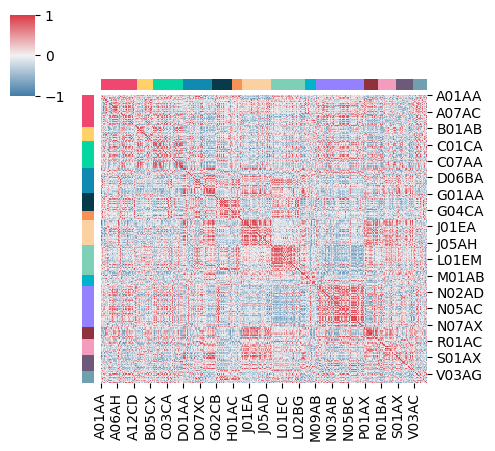

In [10]:
# colors on rows/columns correspond to ATC level 1 categorization
g = sns.clustermap(data=sim_mat, row_colors=level_colors, col_colors= level_colors, 
                   row_cluster=False, col_cluster=False, dendrogram_ratio=0.15,
                   figsize=(5, 4.5), cmap=sns.diverging_palette(240, 10, as_cmap=True),
                   vmin=-1, vmax=1)